In [1]:
from transformers import ViTModel, ViTConfig, AutoImageProcessor, AutoModel
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from PIL import Image
from torchvision import transforms
import torch

/Users/ns/cpet-ai/CPET-AI/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.startswith('heatmap_') and f.endswith('.png')]
        self.image_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort by index number

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Extract index from filename (e.g., 2079 from heatmap_2079.png)
        index = int(self.image_files[idx].split('_')[1].split('.')[0])
        
        return image, index

In [ ]:
# Image transformations
transform_raw = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize to ViT input size
        transforms.ToTensor(),
        # No normalization here - we'll compute and apply global stats later
    ]
)

# We'll need to compute global mean and std across the dataset
def compute_global_stats(dataset):
    loader = DataLoader(dataset, batch_size=32, num_workers=0)
    mean = 0.
    std = 0.
    total_images = 0
    
    # Compute mean
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        total_images += batch_samples
    
    mean = mean / total_images
    
    # Compute std
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        std += ((images - mean.unsqueeze(1))**2).sum([0,2])
    
    std = torch.sqrt(std / (total_images * images.size(2)))
    
    return mean, std


# Load the dataset
dataset = ImageDataset(image_dir='/Users/ns/Downloads/heatmaps', transform=transform_raw)

# Compute global mean and std
mean, std = compute_global_stats(dataset)
print(f"Global mean: {mean}, Global std: {std}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9843137..2.0].


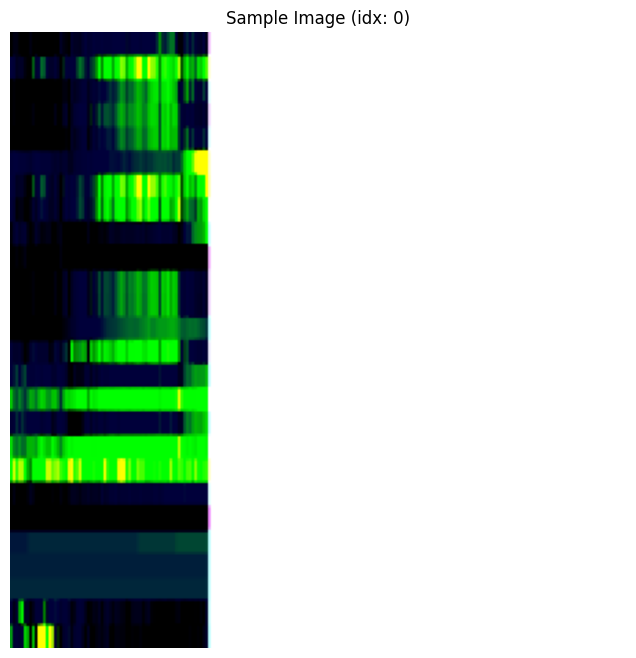

In [6]:
# Display a sample image from the dataset
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize to ViT input size
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],  # These are precomputed global stats, recalculate if the datset changes
            std=[0.25, 0.25, 0.25]  # # These are precomputed global stats, recalculate if the datset changes
        )
    ]
)

transform_raw = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize to ViT input size
        transforms.ToTensor(),
        # No normalization here - we'll compute and apply global stats later
    ]
)

dataset = ImageDataset(image_dir='/Users/ns/Downloads/heatmaps', transform=transform)

# Get a random image from the dataset
idx = 0  # Get first image for reproducibility
image, _ = dataset[idx]

# Convert tensor to numpy for displaying
image_np = image.numpy().transpose(1, 2, 0)  # Change from CxHxW to HxWxC format

# Create figure
plt.figure(figsize=(8, 8))
plt.imshow(image_np)
plt.axis('off')
plt.title(f'Sample Image (idx: {idx})')
plt.show()


In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize to ViT input size
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # These are precomputed global stats, recalculate if the datset changes
            std=[0.229, 0.224, 0.225]  # # These are precomputed global stats, recalculate if the datset changes
        )
    ]
)

# Load pre-trained DINOv2 model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
model = AutoModel.from_pretrained('facebook/dinov2-large')

In [4]:
# Create dataset with normalization transform
dataset = ImageDataset(image_dir='/Users/ns/Downloads/heatmaps', transform=transform)  # Use transform instead of processor

# Create dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract features
features = []
indices = []
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for images, idx in dataloader:
        # Get model outputs
        outputs = model(images)
        
        # For DINOv2, we want the CLS token features
        cls_features = outputs.last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]
        features.append(cls_features)
        indices.extend(idx.tolist())

# Concatenate all features
features = torch.cat(features, dim=0).cpu().numpy()
print(f"Extracted features shape: {features.shape}")

Extracted features shape: (2089, 1024)


In [2]:
# Save features to disk using numpy
import numpy as np
features = np.array(features)  # Convert list to numpy array
np.save('vit_dinov2_features.npy', features)
print(f"Saved features with shape {features.shape} to vit_features.npy")


Saved features with shape (2089, 1033) to vit_features.npy


In [46]:
from preprocess import preprocess_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import numpy as np

use_only_demographics = False  # Set to True to use only demographic features

# Load saved features
features = np.load('vit_dinov2_features.npy', allow_pickle=True)
print(f"Loaded features with shape {features.shape} from vit_features.npy")
df_interpolated, filtered_time_series_columns = preprocess_data('/Users/ns/Downloads/combined_outcome_df.parquet')
y = df_interpolated["Death"]

# Add demographic features to the feature arrays
demographic_columns = ['Gender', 'Age', 'Height', 'Weight', 'TestDuration', 
                      'ExerciseDuration', 'BarometricPress', 'AmbientTemp', 'AmbientRH']

# Convert Gender to numeric (0 for Female, 1 for Male)
df_interpolated['Gender'] = df_interpolated['Gender'].map({'Female': 0, 'Male': 1})

# Get demographic features from df_interpolated
demographic_features = df_interpolated[demographic_columns].values


if use_only_demographics:
    features = demographic_features
    print(f"Using only demographic features with shape: {features.shape}")
else:
    # Combine ViT features with demographic features
    #features = np.hstack([features, demographic_features])
    print(f"Combined features shape after adding demographics: {features.shape}")


Loaded features with shape (2089, 1033) from vit_features.npy
Combined features shape after adding demographics: (2089, 1033)


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Initialize list to store AUC scores
auc_scores = []

# Run 100 iterations with different random splits
for i in range(100):
    # Generate a truly random seed for this iteration
    random_seed = np.random.randint(0, 2**32 - 1)

    # Split data into train/test sets, stratified by outcome
    X_train, X_test, y_train, y_test = train_test_split(
        features, y, 
        test_size=0.3,
        random_state=random_seed,  # Different random state each iteration
        stratify=y,
        shuffle=True
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    # Train logistic regression with L1 regularization and class weights
    model = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=random_seed,
        C=0.1,
        #class_weight=class_weight_dict
    )
    model.fit(X_train_scaled, y_train)

    # Get prediction probabilities
    y_pred_proba = model.predict_proba(X_test_scaled)[:,1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # Print progress every 10 iterations
    if (i + 1) % 10 == 0:
        print(f"Completed {i + 1} iterations...")

# Calculate and print statistics
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
print(f"\nResults over {len(auc_scores)} runs:")
print(f"Mean ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
print(f"Min ROC AUC: {min(auc_scores):.3f}")
print(f"Max ROC AUC: {max(auc_scores):.3f}")


Completed 10 iterations...
Completed 20 iterations...
Completed 30 iterations...
Completed 40 iterations...
Completed 50 iterations...
Completed 60 iterations...
Completed 70 iterations...
Completed 80 iterations...
Completed 90 iterations...
Completed 100 iterations...

Results over 100 runs:
Mean ROC AUC: 0.769 ± 0.043
Min ROC AUC: 0.639
Max ROC AUC: 0.853


In [40]:
from xgboost import XGBClassifier

# Initialize lists to store results
auc_scores = []

# Run multiple iterations
for i in range(10):
    i = np.random.randint(0, 1000)
    # Split data into train/test sets, stratified by outcome 
    X_train, X_test, y_train, y_test = train_test_split(
        features, y,
        test_size=0.3, 
        random_state=i,  # Different random state each iteration
        stratify=y,
        shuffle=True
    )

    # Train XGBoost classifier
    model = XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        random_state=i,
        use_label_encoder=False,
        eval_metric='logloss',
    )
    model.fit(X_train, y_train)

    # Get prediction probabilities
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # Print progress every 10 iterations
    if (i + 1) % 10 == 0:
        print(f"Completed {i + 1} iterations...")

# Calculate and print statistics
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
print(f"\nResults over {len(auc_scores)} runs:")
print(f"Mean ROC AUC: {mean_auc:.3f} ± {std_auc:.3f}")
print(f"Min ROC AUC: {min(auc_scores):.3f}")
print(f"Max ROC AUC: {max(auc_scores):.3f}")


Completed 710 iterations...

Results over 10 runs:
Mean ROC AUC: 0.701 ± 0.028
Min ROC AUC: 0.644
Max ROC AUC: 0.747


In [50]:
# ... existing imports ...
import pandas as pd
from lifelines.utils import concordance_index
from scipy import stats
import xgboost as xgb

# After loading your features and preprocessing...

# Calculate days between Feb 1 2023 and each test date
reference_date = pd.to_datetime('2023-02-01')
years_to_censored = (reference_date - pd.to_datetime(df_interpolated["testDate"])).dt.days/365

# Calculate time to event and event status
time_to_event = np.where(
    pd.isna(df_interpolated["composite_outcome_yrs"]), 
    years_to_censored, 
    df_interpolated["composite_outcome_yrs"]
)
y_event = df_interpolated["composite_outcome"]

# Initialize lists to store results
c_index_scores = []

# Run multiple iterations
for i in range(100):  # Changed from 100 to 10 to match your previous iterations
    # Split data with survival information
    X_train, X_test, y_train_event, y_test_event, y_train_time, y_test_time = train_test_split(
        features, y_event, time_to_event, 
        test_size=0.2, 
        stratify=y_event, 
        random_state=i
    )

    # Create DMatrix objects with survival labels
    dtrain = xgb.DMatrix(X_train)
    dtest = xgb.DMatrix(X_test)

    # Set survival labels
    dtrain.set_float_info('label', y_train_time)
    dtrain.set_float_info('weight', y_train_event)
    dtest.set_float_info('label', y_test_time)
    dtest.set_float_info('weight', y_test_event)

    # Set parameters for survival analysis
    params = {
        'objective': 'survival:cox',
        'eval_metric': ['cox-nloglik'],
        'max_depth': 2,
        'learning_rate': 0.1,
        'tree_method': 'hist',
        'reg_alpha': 0.1,  # L1 regularization
        'reg_lambda': 1.0,  # L2 regularization
        'min_child_weight': 3,  # Minimum sum of instance weight needed in a child
        'subsample': 0.8,  # Subsample ratio of training instances
        'colsample_bytree': 0.8  # Subsample ratio of columns when constructing each tree
    }

    # Train model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=False
    )

    # Calculate C-index
    test_risk_scores = model.predict(dtest)
    c_index = concordance_index(y_test_time, -test_risk_scores, y_test_event)
    c_index_scores.append(c_index)

    # Print progress
    if (i + 1) % 10 == 0:
        print(f"Completed {i + 1} iterations...")

# Calculate and print statistics
mean_c_index = np.mean(c_index_scores)
ci_lower, ci_upper = stats.norm.interval(0.95, loc=mean_c_index, scale=stats.sem(c_index_scores))

print(f"\nResults over {len(c_index_scores)} runs:")
print(f'Mean C-index: {mean_c_index:.4f}')
print(f'95% CI: ({ci_lower:.4f}, {ci_upper:.4f})')

# Get feature importance from final model
importance = model.get_score(importance_type='gain')
importance = pd.Series(importance).sort_values(ascending=False)
print("\nTop 10 most important features:")
print(importance.head(10))

Completed 10 iterations...
Completed 20 iterations...
Completed 30 iterations...
Completed 40 iterations...
Completed 50 iterations...
Completed 60 iterations...
Completed 70 iterations...
Completed 80 iterations...
Completed 90 iterations...
Completed 100 iterations...

Results over 100 runs:
Mean C-index: 0.5496
95% CI: (0.5419, 0.5573)

Top 10 most important features:
f405    220.900330
f488    220.515747
f989    179.658936
f950     73.472412
f23      72.311279
f79      69.180298
f529     62.899414
f652     54.786087
f135     37.096924
f69      34.295410
dtype: float64
